Code By Arjit Sakhuja UTA ID: (1001446053)

# Introduction

Here we will work on a project which involves solving business problems for a hypothetical music store named "Chinook" which stores all of its data in SQLite database. So, we will use SQL and Python to fetch the data, answer the critical questions and perform the tasks along the way. You can see the schema of the database below.

## Database Schema

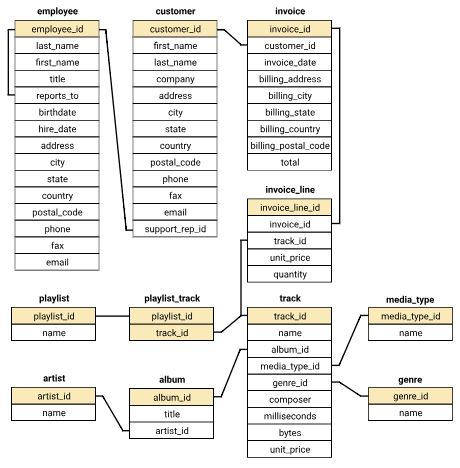

In [6]:
from IPython.display import Image
Image(filename='schema.jpg')

## Import necessary modules

In [2]:
import os
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
os.chdir(r'E:\Projects\Project_ SQL')

In [2]:
db = 'chinook.db'
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q1 = '''SELECT
    name,
    type
    FROM sqlite_master
    WHERE type IN ("table","view");'''
    return run_query(q1)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Task 1

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

Artist Name --------------Genre<br>
Regal---------------------Hip-Hop<br>
Red Tone------------------Punk<br>
Meteor and the Girls------Pop<br>
Slim Jim Bites------------Blues<br>

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

You'll need to write a query to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.

In [4]:
top_genre = '''
WITH usa_tracks AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(ut.invoice_line_id) tracks_sold,
    cast(count(ut.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks
    ) tracks_sold_perc
FROM usa_tracks ut
INNER JOIN track t on t.track_id = ut.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''
df_top10_genre = run_query(top_genre)
run_query(top_genre)

,genre,tracks_sold,tracks_sold_perc
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


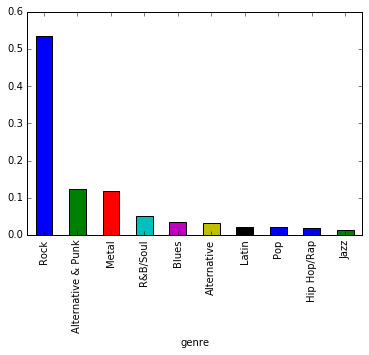

In [5]:
df_top10_genre.set_index("genre",drop=True,inplace=True)
df_top10_genre['tracks_sold_perc'].plot(kind='bar')
plt.show()

Based on the visulaization above, we should purchase the new albums by the following artists:

1. Red Tone (Punk)<br>
2. Slim Jim Bites (Blues)<br>
3. Meteor and the Girls (Pop) <br>

It shuld be noticed that these three genres only make up only 17% of total sales, so we should be lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

## Task 2

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

We might like to consider whether any extra columns from the employee table explain any variance we see, or whether the variance might instead be indicative of employee performance.

In [4]:
emp_sales = '''WITH emp_table AS
               ( SELECT e.employee_id ,
                        e.first_name ||" " || e.last_name emp_name,
                        SUM(i.total) sales
                        FROM customer c
                        INNER JOIN employee e ON c.support_rep_id=e.employee_id
                        INNER JOIN invoice i ON c.customer_id = i.customer_id
                        GROUP BY 1,2
                        ORDER BY sales DESC
                )
                   SELECT et.emp_name,
                          em.hire_date,
                          et.sales, 
                          em.title, 
                          em.country, 
                          em.state,em.city 
                   FROM emp_table et INNER JOIN employee em 
                        ON et.employee_id= em.employee_id;
        
                '''
run_query(emp_sales)

,emp_name,hire_date,sales,title,country,state,city
0,Jane Peacock,2017-04-01 00:00:00,1731.51,Sales Support Agent,Canada,AB,Calgary
1,Margaret Park,2017-05-03 00:00:00,1584.00,Sales Support Agent,Canada,AB,Calgary
2,Steve Johnson,2017-10-17 00:00:00,1393.92,Sales Support Agent,Canada,AB,Calgary


It is evident that there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee) but the difference roughly corresponds with the differences in their hiring dates. Here we can not say with confidence that some employees are better than others. 

## Task 3

Here we have been asked to analyze the sales data for customers from each different country. We have been given guidance to use the country value from the customers table, and ignore the country from the billing address in the invoice table.

In particular, we have been directed to calculate data, for each country, on the:

- total number of customers<br>
- total value of sales<br>
- average value of sales per customer<br>
- average order value<br>

Because there are a number of countries with only one customer, we should group these customers as "Other" in our analysis.

Also, we will make the visualizations to interpret data easily.

In [15]:
c1 = '''CREATE VIEW ountry_sales_1 AS
       SELECT CASE
                  WHEN no_of_customers =1 THEN 'other'
                  ELSE country
              END AS country_modified,
              SUM(total_sales) total_sales,
              SUM(no_of_customers) total_customers,
              SUM(no_of_orders) total_orders,
              total_sales/no_of_customers sales_per_customer,
              total_sales/no_of_orders avg_order_value
       FROM country_sales
       GROUP BY country_modified;
'''
run_command(c1)

In [9]:
q2 = 'select * from country_sales_1 ORDER BY total_sales DESC limit 10;'
run_query(q2)

,country_modified,total_sales,total_customers,total_orders,sales_per_customer,avg_order_value
0,other,1094.94,15,147,75.240000,7.524000
1,USA,1040.49,13,131,80.037692,7.942672
2,Canada,535.59,8,76,66.948750,7.047237
3,Brazil,427.68,5,61,85.536000,7.011148
4,France,389.07,5,50,77.814000,7.781400
5,Germany,334.62,4,41,83.655000,8.161463
6,Czech Republic,273.24,2,30,136.620000,9.108000
7,United Kingdom,245.52,3,28,81.840000,8.768571
8,Portugal,185.13,2,29,92.565000,6.383793
9,India,183.15,2,21,91.575000,8.721429


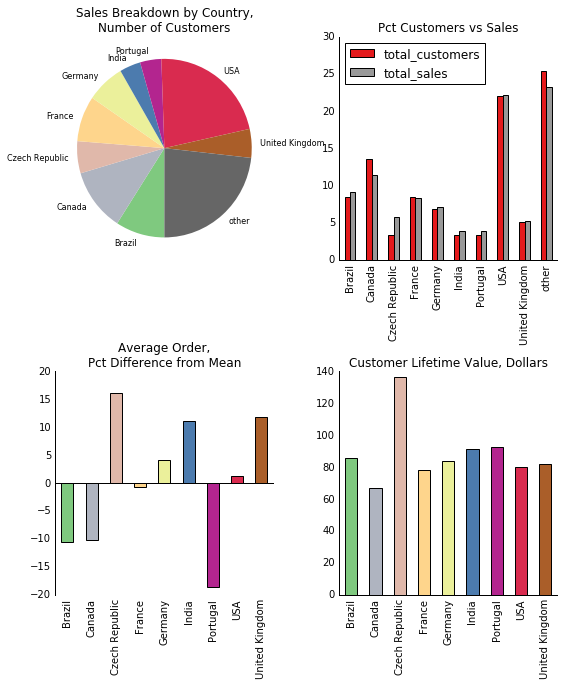

In [26]:
import numpy as np
country_metrics = run_query(sales_data)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["total_customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["avg_order_value"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["sales_per_customer"].copy()
ltv.index.name = ''
ltv.drop("other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the visulaizations, we can see that there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India<br><br>
But the data for these countries is relativly low. therefore, we should be cautious in spending too much money on new marketing campaigns. It would be better to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

## Task 4

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.<br><br>
The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [22]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Here we can see that customers purchase the whole album around 18.6% of the times. Based on our finding, I would not suggest management to purchase only select tracks from albums from record companies because there is potential to lose one fifth of revenue.

